In [27]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

# data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

In [29]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

In [30]:
data.head()

,TV_ANE,TV_AMC,TV_ANIMALPLANET,TV_BBCAMERICA,TV_BET,TV_BETHER,TV_BRAVO,TV_COMEDYCENTRAL,TV_COUNTRYMUSICTELEVISION,TV_FOODNETWORK,...,TV_SMITHSONIANNETWORK,TV_SYFY,TV_TRUTV,TV_TVONE,TV_USANETWORK,TV_VH1,TV_WETV,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39,0.0,16
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.00,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0


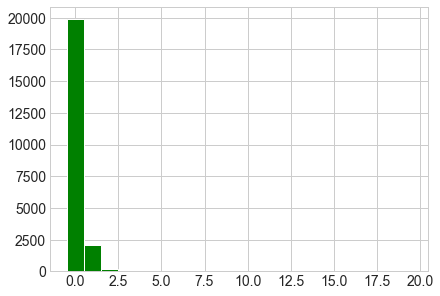

In [31]:
plt.bar(data.TOTAL_CONV.value_counts().index, data.TOTAL_CONV.value_counts(), width=1, color = 'green')
plt.show()

In [32]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [33]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        # Likelihood
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu, 
                                   alpha= eps,  
                                   observed=y)
        # trace_negative_binomial = pm.sample(chains = 2, target_accept = 0.95)

In [34]:
# Loading Saved Trace
with model_negative_binomial:
    trace_negative_binomial = pm.load_trace(
        directory=r"c:\Users\izakharchuk\Documents\Sistas_3\traces\trace_nb")

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


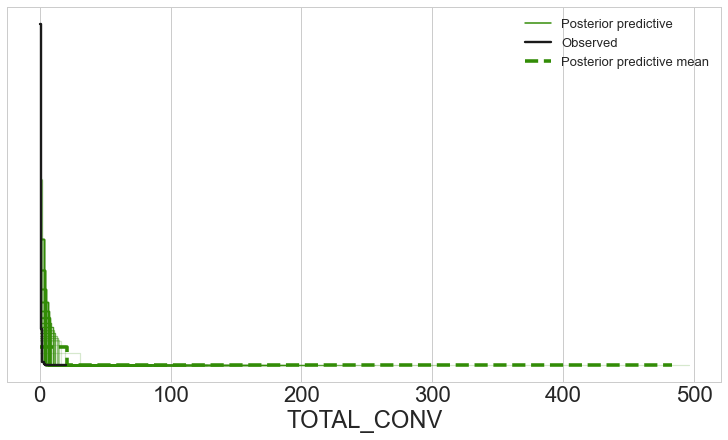

R2 for Model is : 0.605


In [35]:
predictions_negative_binomial = ppc_check(model = model_negative_binomial, 
                            data = data, 
                            trace = trace_negative_binomial, 
                                          
                            predictions= True)

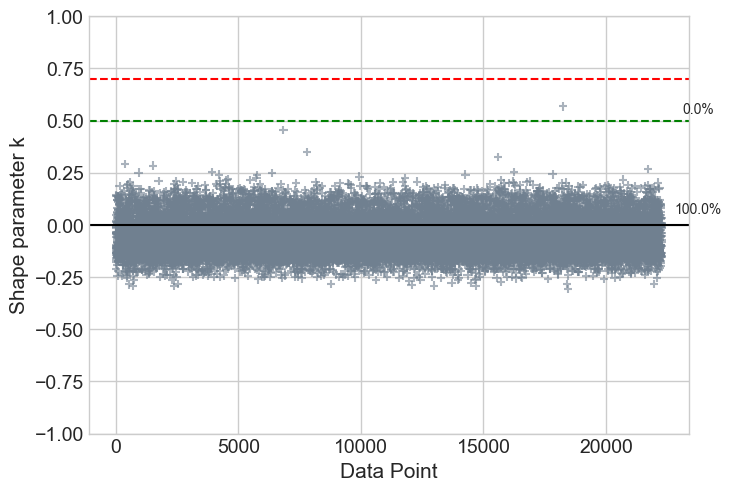

In [36]:
# compute with arviz InferenceData type
p_loo_zinb = pm.loo(trace_negative_binomial, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(p_loo_zinb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

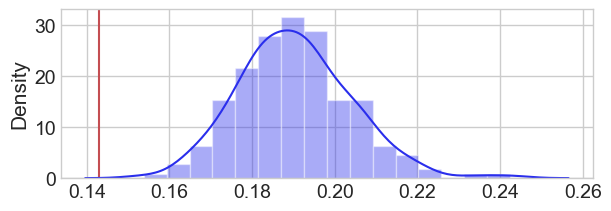

In [37]:
samples_mean = [sample.mean() for sample in predictions_negative_binomial['conv']]

plt.figure(figsize=(6,2))
ax = sns.distplot(samples_mean,)
plt.vlines(y.mean(), *ax.set_ylim(), color='r')
plt.show()

In [17]:
predictions_negative_binomial['conv'].flatten().mean()

0.7753460680775865

In [38]:
az.summary(trace_negative_binomial, var_names='beta')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.000,0.000,0.000,0.001,0.0,0.0,4249.0,1851.0,1.00
beta[1],0.001,0.001,0.000,0.001,0.0,0.0,3124.0,1792.0,1.00
beta[2],0.000,0.000,0.000,0.001,0.0,0.0,4119.0,1898.0,1.00
beta[3],0.004,0.004,0.000,0.012,0.0,0.0,4961.0,2355.0,1.00
beta[4],0.000,0.000,0.000,0.000,0.0,0.0,4352.0,1823.0,1.00
beta[5],0.004,0.005,0.000,0.013,0.0,0.0,4025.0,1934.0,1.00
beta[6],0.000,0.000,0.000,0.001,0.0,0.0,4427.0,2095.0,1.00
beta[7],0.001,0.001,0.000,0.002,0.0,0.0,3918.0,1919.0,1.00
beta[8],0.000,0.000,0.000,0.001,0.0,0.0,5186.0,2345.0,1.00
beta[9],0.000,0.000,0.000,0.001,0.0,0.0,4370.0,2111.0,1.00
